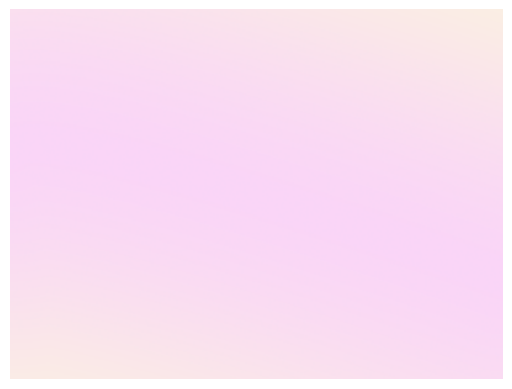

In [5]:
import numpy as np
from PIL import Image
import random
import math
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def linear_interpolation(color1, color2, t):
    return (np.array(color1)[:, None] * (1 - t) + np.array(color2)[:, None] * t).T

def sigmoid(x, a=1.0, b=0.0):
    return 1 / (1 + np.exp(-a * (x - b)))

def softstep(x, slope=1.0):
    return (1 / (1 + np.exp(-slope * (x - 0.5))))

def sort_points_by_x(points):
    return sorted(points, key=lambda p: p[0])

def sort_points_by_distance(points):
    if len(points) <= 1:
        return points

    sorted_points = [points.pop(random.randint(0, len(points) - 1))]

    while points:
        last_point = sorted_points[-1]
        distances = [distance(last_point[0], last_point[1], p[0], p[1]) for p in points]
        nearest_index = np.argmin(distances)
        sorted_points.append(points.pop(nearest_index))
    
    return sorted_points

def point_to_curve_distance(x, y, t_values, cx, cy):
    """For each pixel coordinate (x, y), calculates the distance to the nearest point on the spline curve"""
    curve_x = cx(t_values)
    curve_y = cy(t_values)
    
    # Efficient distance calculations using broadcasts
    distances = np.sqrt((x[:, None] - curve_x[None, :]) ** 2 + (y[:, None] - curve_y[None, :]) ** 2)
    
    # Get the shortest distance for each pixel
    min_distances = np.min(distances, axis=1)
    return min_distances

def generate_spline_gradient_image(width, height, points, start_color, end_color, max_distance):
    t_values_points = np.linspace(0, 1, num=len(points))

    points_x = [p[0] for p in points]
    points_y = [p[1] for p in points]

    cx = CubicSpline(t_values_points, points_x)
    cy = CubicSpline(t_values_points, points_y)
    
    data = np.zeros((height, width, 3), dtype=np.uint8)

    x, y = np.meshgrid(np.arange(width), np.arange(height))
    x = x.flatten()
    y = y.flatten()

    t_values = np.linspace(0, 1, num=500)
    point_distance = point_to_curve_distance(x, y, t_values, cx, cy)
    
    # Apply a nonlinear function based on distance (e.g., softstep)
    normalized_distance = point_distance / max_distance
    softstep_distance = softstep(normalized_distance, slope=5.0)  
    ratio = np.clip(softstep_distance, 0, 1)
    
    colors = linear_interpolation(start_color, end_color, ratio).astype(np.uint8)
    data = colors.reshape((height, width, 3))

    img = Image.fromarray(data)
    
    return img, cx, cy

def plot_curve(cx, cy, points):
    t_values = np.linspace(0, 1, num=500)
    curve_x = cx(t_values)
    curve_y = cy(t_values)

    plt.scatter(*zip(*points), color='red')
    plt.plot(curve_x, curve_y, color='blue')

def choose_vibrant_colors(min_value=210, max_value=250):
    while True:
        # Randomly select an color components
        start_index = random.randint(0, 2)
        end_index = random.randint(0, 2)
        
        # Generate start color
        start_color = [250, 250, 250]  # First, set all components to 250
        start_color[start_index] = random.randint(min_value, max_value)  # Random component set to 210-250
        
        # Generate end color
        end_color = [250, 250, 250]  # Similarly set all components to 250
        end_color[end_index] = random.randint(min_value, max_value)  # Random component set to 210-250

        RGB_distance = 0
        for i in range(3):
            RGB_distance += abs(start_color[i] - end_color[i])

        # Exit the loop as a decision when the start and end colors are different and 20 or more colors are added.
        if start_color != end_color and RGB_distance > 20:
            return tuple(start_color), tuple(end_color)

# image setting
width, height = 400, 300

# generate points for curve
points = [(0, random.randint(0, height)), 
          (random.randint(int(width/4), int(width*3/4)), 
           random.randint(int(height/4), int(height*3/4))), 
          (width, random.randint(0, height))]

# For curves with multiple points
sorted_points = sort_points_by_x(points)

# color setting
start_color, end_color = choose_vibrant_colors()

# Parameters for gradient effects. Depends on width and height
max_distance = 300

# main
spline_gradient_image, cx, cy = generate_spline_gradient_image(width, height, sorted_points, start_color, end_color, max_distance)

# visualization
plt.imshow(spline_gradient_image)
# plot_curve(cx, cy, sorted_points)  # curve checking
plt.axis('off')
plt.show()

# save
spline_gradient_image.save("output.png")

In [1]:
# 赤系統